In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import numpy as np

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [2]:
train_dir = './train_withoout_callback'

In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    #featurewise_center=True, #center 중심 유지
    #featurewise_std_normalization=True, #normalization
    rotation_range=25.0,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #brightness_range=[0.2,1.0],
    zoom_range=[0.8,1.2],
    horizontal_flip=True,
    validation_split=0.2) #수평방향 뒤집기

Using TensorFlow backend.


In [4]:
train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(224,224),
        batch_size=32,
        subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(224,224),
    batch_size=32,
    subset='validation') # set as validation data

Found 1372 images belonging to 4 classes.
Found 340 images belonging to 4 classes.


In [4]:
from keras import models, layers
from keras import Input
from keras.applications import InceptionV3
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [10]:
for layer in model.layers:
    layer.trainable=False

x=model.output
x=layers.Flatten()(x)
x=Dense(1024, activation='relu')(x)
outputs=Dense(4, activation='softmax')(x)

additional_model=Model(inputs=model.input, outputs=outputs)

additional_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [11]:
def f1score(precision, recall):
    _f1score = ( 2 * recall * precision) / (recall + precision)
    
    # return a single tensor value
    return _f1score

In [12]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='png_Inceptionv3_finetuning.hdf5', 
            monitor='val_loss', 
            mode='min', 
            save_best_only=True)

In [13]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [10]:
history = additional_model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples /32,
      epochs=3,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples/32,
      callbacks=[checkpoint])

Epoch 1/3
43/42 [==============================] - 22s 502ms/step - loss: 2.4017 - acc: 0.2966 - auc: 0.5255 - precision: 0.2749 - recall: 0.1922 - f1score: 0.0967 - val_loss: 1.4903 - val_acc: 0.2882 - val_auc: 0.5592 - val_precision: 0.3119 - val_recall: 0.1367 - val_f1score: 0.1048
Epoch 2/3
43/42 [==============================] - 13s 298ms/step - loss: 1.2713 - acc: 0.4118 - auc: 0.5893 - precision: 0.3430 - recall: 0.1212 - f1score: 0.1167 - val_loss: 1.2152 - val_acc: 0.3382 - val_auc: 0.6100 - val_precision: 0.3805 - val_recall: 0.1180 - val_f1score: 0.1082
Epoch 3/3
43/42 [==============================] - 15s 359ms/step - loss: 1.2391 - acc: 0.4096 - auc: 0.6223 - precision: 0.4043 - recall: 0.1217 - f1score: 0.1199 - val_loss: 1.2579 - val_acc: 0.3382 - val_auc: 0.6362 - val_precision: 0.4227 - val_recall: 0.1229 - val_f1score: 0.1104


In [11]:
for layer in additional_model.layers[:300]:
    layer.trainable=False

for layer in additional_model.layers[300:]:
    layer.trainable=True

In [12]:
for layer in additional_model.layers:
    print(layer, layer.trainable)
    
additional_model.summary()

<keras.engine.input_layer.InputLayer object at 0x00000207FA50F9C8> False
<keras.layers.convolutional.Conv2D object at 0x00000207FA516108> False
<keras.layers.normalization.BatchNormalization object at 0x00000207FA516B08> False
<keras.layers.core.Activation object at 0x00000207FA51F208> False
<keras.layers.convolutional.Conv2D object at 0x00000207FA534748> False
<keras.layers.normalization.BatchNormalization object at 0x00000207EB0A8F08> False
<keras.layers.core.Activation object at 0x00000207EB0A8E88> False
<keras.layers.convolutional.Conv2D object at 0x00000207EB0A0D08> False
<keras.layers.normalization.BatchNormalization object at 0x00000207EB0C5F48> False
<keras.layers.core.Activation object at 0x00000207EB0D0C08> False
<keras.layers.pooling.MaxPooling2D object at 0x00000207EB0ECC48> False
<keras.layers.convolutional.Conv2D object at 0x00000207EB0ECE08> False
<keras.layers.normalization.BatchNormalization object at 0x00000207EB138588> False
<keras.layers.core.Activation object at 0x

C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [13]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [14]:
history = additional_model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples /32,
      epochs=5,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples/32,
      callbacks=[checkpoint])

Epoch 1/5
43/42 [==============================] - 19s 448ms/step - loss: 1.1119 - acc: 0.4701 - auc_1: 0.7807 - precision_1: 0.6233 - recall_1: 0.1402 - f1score: 0.1290 - val_loss: 1.2944 - val_acc: 0.3853 - val_auc_1: 0.7605 - val_precision_1: 0.5997 - val_recall_1: 0.1538 - val_f1score: 0.1135
Epoch 2/5
43/42 [==============================] - 14s 329ms/step - loss: 1.0667 - acc: 0.5117 - auc_1: 0.7655 - precision_1: 0.6121 - recall_1: 0.1669 - f1score: 0.1337 - val_loss: 1.5175 - val_acc: 0.3588 - val_auc_1: 0.7639 - val_precision_1: 0.6114 - val_recall_1: 0.1750 - val_f1score: 0.1125
Epoch 3/5
43/42 [==============================] - 16s 381ms/step - loss: 1.0900 - acc: 0.5080 - auc_1: 0.7621 - precision_1: 0.6018 - recall_1: 0.1792 - f1score: 0.1327 - val_loss: 1.2974 - val_acc: 0.3765 - val_auc_1: 0.7601 - val_precision_1: 0.5945 - val_recall_1: 0.1849 - val_f1score: 0.1136
Epoch 4/5
43/42 [==============================] - 16s 381ms/step - loss: 1.0804 - acc: 0.5219 - auc_1: 0.

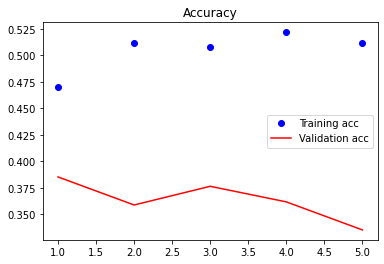

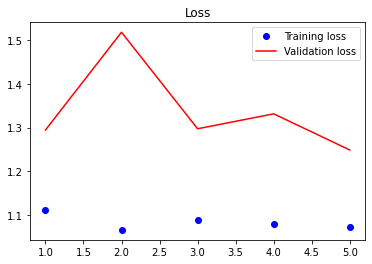

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [16]:
for layer in additional_model.layers:
    layer.trainable=True

In [17]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-6),
              metrics=['acc',tf.keras.metrics.AUC(name='auc'),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

history = additional_model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples /32,
      epochs=10,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples/32,
      callbacks=[checkpoint])

Epoch 1/10
43/42 [==============================] - 33s 767ms/step - loss: 1.0433 - acc: 0.5255 - auc: 0.8037 - precision_2: 0.6723 - recall_2: 0.2509 - f1score: 0.1366 - val_loss: 1.1140 - val_acc: 0.4029 - val_auc: 0.7941 - val_precision_2: 0.6459 - val_recall_2: 0.2479 - val_f1score: 0.1227
Epoch 2/10
43/42 [==============================] - 14s 328ms/step - loss: 1.0591 - acc: 0.5496 - auc: 0.7879 - precision_2: 0.6480 - recall_2: 0.2459 - f1score: 0.1361 - val_loss: 1.1921 - val_acc: 0.4265 - val_auc: 0.7915 - val_precision_2: 0.6573 - val_recall_2: 0.2493 - val_f1score: 0.1228
Epoch 3/10
43/42 [==============================] - 17s 400ms/step - loss: 1.0431 - acc: 0.5233 - auc: 0.7905 - precision_2: 0.6491 - recall_2: 0.2495 - f1score: 0.1375 - val_loss: 1.1358 - val_acc: 0.3971 - val_auc: 0.7895 - val_precision_2: 0.6490 - val_recall_2: 0.2522 - val_f1score: 0.1207
Epoch 4/10
43/42 [==============================] - 17s 401ms/step - loss: 1.0231 - acc: 0.5525 - auc: 0.7898 - pre

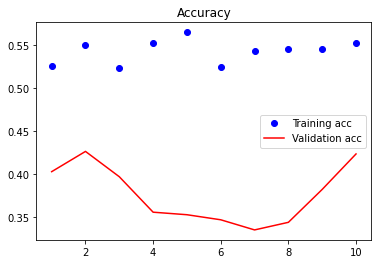

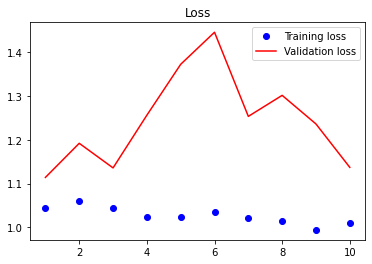

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [19]:
_loss, _acc, _auc, _precision, _recall, _f1score =  additional_model.evaluate_generator(validation_generator, steps=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

loss: 1.256, accuracy: 0.411, auc: 0.787, precision: 0.637, recall: 0.256, f1score: 0.119


In [14]:
from keras.models import Model, load_model

new_model = models.load_model('png_Inceptionv3_finetuning.hdf5',compile=False)


new_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [15]:
test_dir='./test_without_callback'

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32)

Found 571 images belonging to 4 classes.


In [16]:
_loss, _acc, _auc, _precision, _recall, _f1score =new_model.evaluate_generator(test_generator, steps=test_generator.samples/32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

loss: 1.194, accuracy: 0.438, auc: 0.729, precision: 0.614, recall: 0.166, f1score: 0.125
